In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from wmfdata import charting, hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
charting.set_mpl_style()

In [3]:
# Metric month. The mediawiki_history snapshot for this month must be available.
METRICS_MONTH_TEXT = "2019-02"
MEDIAWIKI_HISTORY_SNAPSHOT = "2019-02"

metrics_month = pd.Period(METRICS_MONTH_TEXT)
insert_start = "2001-01" # str(metrics_month)
insert_end = "2019-03" # str(metrics_month + 1)
graph_start = str(metrics_month - 48)

# Update table

In [4]:
create_cmd = Path("queries/create_editor_month.sql").read_text()
update_cmd = Path("queries/update_editor_month.sql").read_text().format(
    start=insert_start,
    end=insert_end,
    mwh_snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
)

hive.run(create_cmd)
hive.run(update_cmd)

# Quality checks

In [5]:
editors = hive.run("""
select
    month,
    count(*) as editors,
    sum(cast(content_edits >= 5 as int)) as active_editors,
    sum(cast(content_edits >= 100 as int)) as very_active_editors
from neilpquinn.editor_month 
group by month
order by month asc
limit 1000
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,active_editors,very_active_editors
month,,,
2018-10-01,398562,98697,15346
2018-11-01,395705,98924,15096
2018-12-01,380474,97508,15344
2019-01-01,413692,105127,16602
2019-02-01,392886,100285,15418


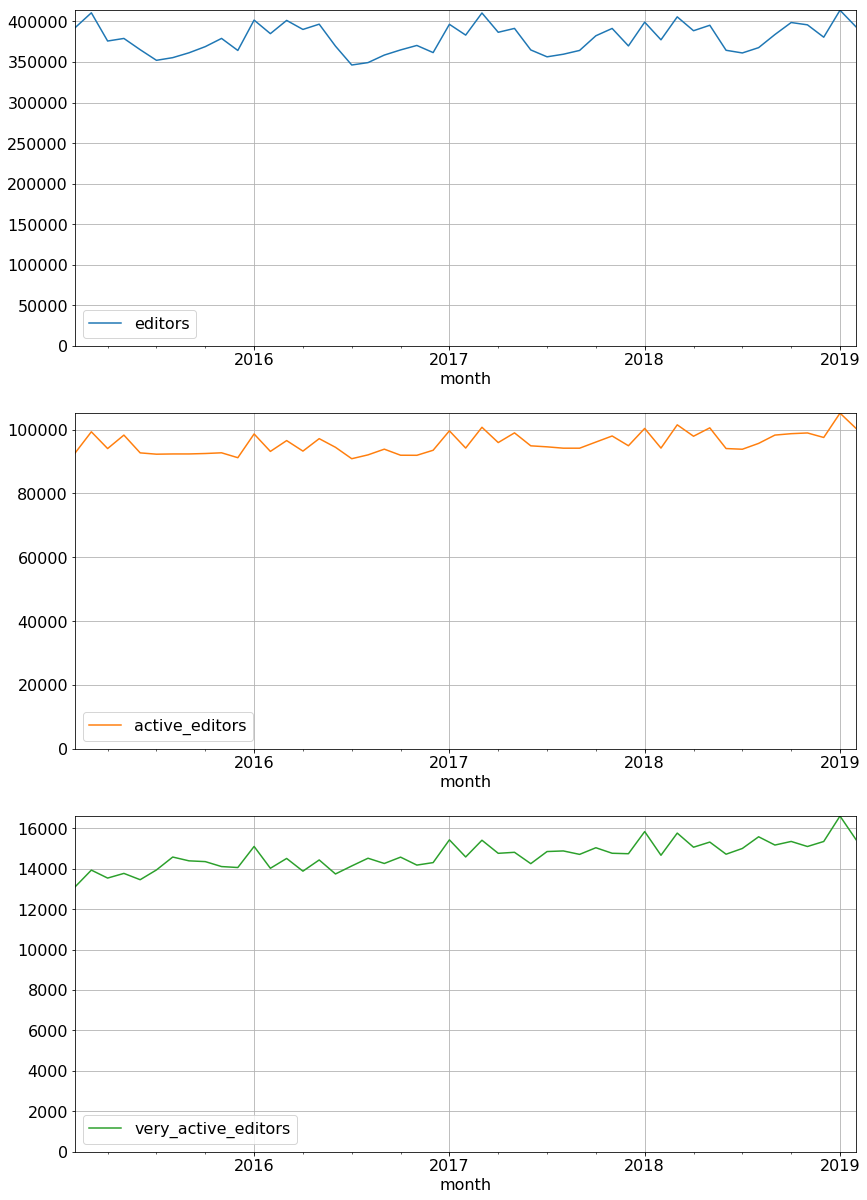

In [6]:
ax = editors[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 21),
    sharex=False
)

In [7]:
editors_per_wiki = hive.run("""
select
    month,
    wiki_db,
    count(*) as editors 
from neilpquinn.editor_month 
where
    wiki_db in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by month, wiki_db
order by month, wiki_db
limit 10000
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki_db")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki_db,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2018-10-01,5653.0,20602.0,141596.0,2344.0,8380.0
2018-11-01,5045.0,20611.0,140004.0,2463.0,8248.0
2018-12-01,5524.0,19325.0,132033.0,2385.0,8377.0
2019-01-01,5204.0,22558.0,143453.0,2169.0,8759.0
2019-02-01,4432.0,20414.0,136248.0,2029.0,7844.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f78ea69b208>,
      dtype=object)

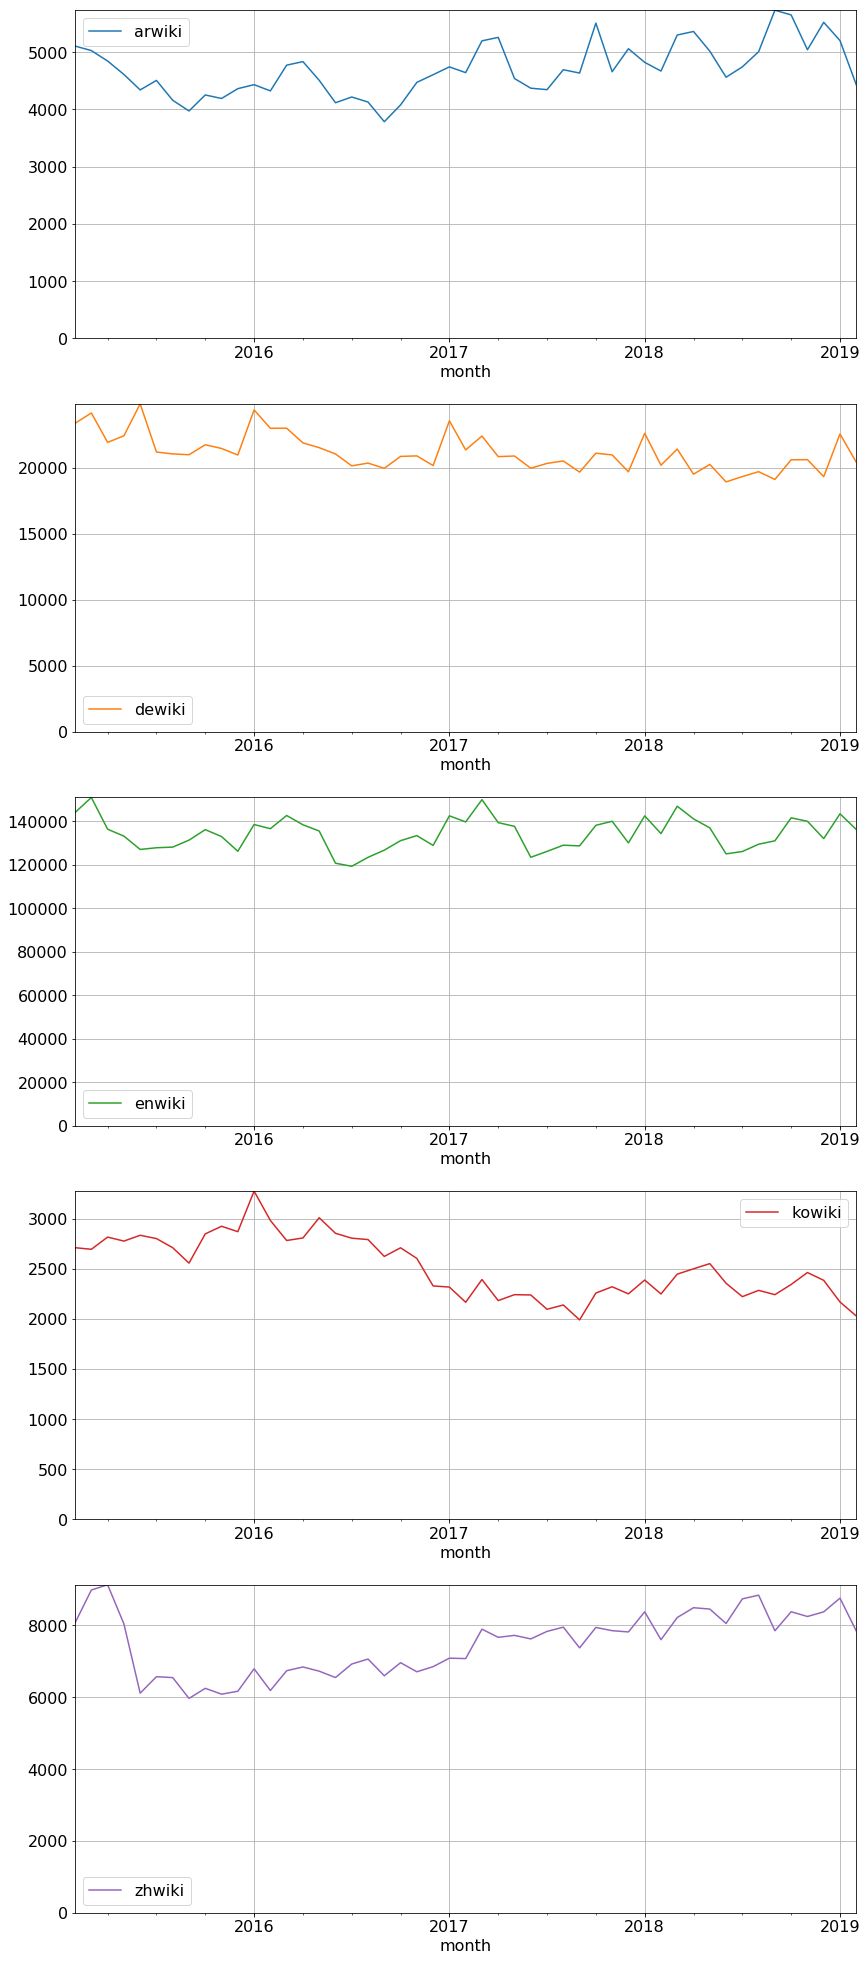

In [8]:
editors_per_wiki[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 35),
    sharex=False
)